In [2]:
%matplotlib inline

In [3]:
from __future__ import division

In [4]:
import gdist
import numpy as np
import pandas as pd
from pqdict import PQDict
#from mayavi import mlab
import seaborn as sns
from scipy import stats as stats
import scipy as sp
import matplotlib.pyplot as plt
from vtk_rw import read_vtk, write_vtk
from graphs import graph_from_mesh, dijkstra, shortest_path, sorted_path
from plotting import plot_surf_stat_map, plot_surf_label
from jensen_shannon import jensenshannon
from scipy.signal import argrelmax
from mapalign import dist as mdist
from mapalign import embed as membed
import pickle
import operator
import matplotlib

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

In [6]:
def kmeans(embedding,n_components):
    import numpy as np
    from sklearn.cluster import KMeans
    
    est = KMeans(n_clusters=n_components, n_jobs=-2, init='k-means++', n_init=300)
    est.fit_transform(embedding)
    labels = est.labels_
    kmeans_results = labels.astype(np.float)
    kmeans_results += 1
    return kmeans_results

In [7]:
def prob_mass_function(data, bins='auto', range_min=None, range_max=None):
    data = data.flatten()
    if range_min is None:
        range_min = np.nanmin(data)
    if range_max is None:
        range_max = np.nanmax(data)
    if bins == 'auto':
        bins = data.shape[0]/10
    p_mass, x_values = np.histogram(data, bins=bins, range=(range_min, range_max))
    p_mass = p_mass / data.shape[0]
    x_values = x_values[:-1] + (x_values[1] - x_values[0])/2
    return p_mass, x_values

def jensenshannon(data, range_min=None, range_max=None, base=2, weights=None):
    if range_min is None:
        data_mins = [np.nanmin(m) for m in data]
        range_min = data_mins[np.argmin(data_mins)]
    if range_max is None:
        data_maxs = [np.nanmax(n) for n in data]
        range_max = data_maxs[np.argmax(data_maxs)]
    data_shapes = [k.shape[0] for k in data]
    bins = int(np.round(data_shapes[np.argmin(data_shapes)]/10))
    p_mass = np.zeros((len(data), bins))
    combined_data = []
    for i in range(len(data)):
        p_mass[i], _ = prob_mass_function(data[i], bins, range_min, range_max)
        combined_data += list(data[i])
    p_mass_combined, _ = prob_mass_function(np.asarray(combined_data), bins, range_min, range_max)
    shannon_entropy = [sp.stats.entropy(p_mass[j], base=base) for j in range(p_mass.shape[0])]
    shared_shannon_entropy = sp.stats.entropy(p_mass_combined, base=base)
    if weights is None:
        weights = 1/len(data)
    shannon_entropy = np.asarray(shannon_entropy) * np.asarray(weights)
    jsdivergence = shared_shannon_entropy - np.sum(shannon_entropy)
    jsdistance = np.sqrt(jsdivergence)
    return jsdivergence, jsdistance

In [8]:
def make_div_cmap(c):
    cmap= np.asarray(sns.diverging_palette(240, 15, n=c, sep=1, center='dark'))
    #cmap = np.concatenate((np.array([[0.8,0.8,0.8,1]]), cmap), axis=0)
    #cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [9]:
mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d_sulc.npy'
fc_embed_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/old_mapping/clust/smooth_3/mask_025_5/rh_embed_10.npy'
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_rh_profiles_smooth_3.npy'
windows_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/windows_longpath3_rad4.pkl'
#corr_dict_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/old_mapping/path/corr_windows_longpath3_rad4.pkl'
corr_dict_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/newcorr_windows_longpath3_rad4.pkl'

In [10]:
v_inf, f_inf, _ = read_vtk('/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d_infl_laplacian100.vtk')

In [11]:
v,f,d=read_vtk(mesh_file)
vertices = v.astype(np.float64)
faces = f.astype(np.int32)
sulc = np.load(sulc_file)
profiles = np.load(t1_file)[:,3:8]
fc_embed = np.load(fc_embed_file)
with open(windows_file, 'r') as pkl_in:
    windows = pickle.load(pkl_in)
with open(corr_dict_file, 'r') as pkl_in:
    corr_dict = pickle.load(pkl_in)

In [12]:
halfwidth = 2
overlap = 0

In [13]:
combined_windows=[]
for window in np.arange(start=halfwidth, stop=len(windows)-halfwidth, step=2*halfwidth-overlap):
    combined_window=[]
    for k in range(window-halfwidth,window+halfwidth):
        combined_window+=windows[k]
    combined_windows.append(combined_window)

In [14]:
#combined_windows=combined_windows[13:]

In [15]:
fullpath=[]
for window in combined_windows:
    fullpath+=window
fullpath=np.unique(fullpath)

In [16]:
cheb_windows=[]
cheb_avg=[]
for window in combined_windows:
    coeff, poly = chebapprox(profiles[window], degree=4)
    cheb_windows.append(coeff)
    cheb_avg.append(np.mean(coeff, axis=0))
cheb_avg = np.nan_to_num(np.asarray(cheb_avg))

cheb_avg_affinity = mdist.compute_affinity(cheb_avg, method='markov')
cheb_avg_embed = membed.compute_diffusion_map(cheb_avg_affinity, n_components=10)

In [17]:
cheb_mid = np.percentile(cheb_avg, 50, axis=0)
cheb_range = np.percentile(cheb_avg, 75, axis=0) -np.percentile(cheb_avg, 25, axis=0)
cheb_avg_norm = (cheb_avg - cheb_mid) / cheb_range

cheb_avg_norm_affinity = mdist.compute_affinity(cheb_avg_norm[:,0:2], method='markov')
cheb_avg_norm_embed = membed.compute_diffusion_map(cheb_avg_norm_affinity, n_components=10)

In [18]:
t1_windows=[]
t1_windows_avg=[]
for window in combined_windows:
    intra_avg = np.mean(profiles[window], axis=1)
    t1_windows.append(intra_avg)
    t1_windows_avg.append(np.mean(intra_avg))
t1_windows_avg = np.nan_to_num(t1_windows_avg)

In [19]:
corr_windows=[]
corr_avg=[]
for window in combined_windows:
    warray = np.zeros((len(window), len(fullpath)))
    for w in range(len(window)):
        warray[w]=np.nan_to_num(corr_dict[window[w]][fullpath])
    corr_windows.append(warray)
    corr_avg.append(np.tanh(np.mean(np.arctanh(warray), axis=0)))
corr_avg = np.nan_to_num(np.asarray(corr_avg))

corr_avg_affinity = mdist.compute_affinity(corr_avg)
corr_avg_embed = membed.compute_diffusion_map(corr_avg_affinity, n_components=10)

In [20]:
sulc_windows=[]
sulc_avg=[]
for window in combined_windows:
    sulc_windows.append(sulc[window])
    sulc_avg.append(np.mean(sulc[window], axis=0))

In [21]:
print 'cheb 0', 'corr 0', sp.stats.pearsonr(cheb_avg_embed[0][:,0], corr_avg_embed[0][:,0])
print 'cheb 0', 'corr 1', sp.stats.pearsonr(cheb_avg_embed[0][:,0], corr_avg_embed[0][:,1])
print 'cheb 1', 'corr 0', sp.stats.pearsonr(cheb_avg_embed[0][:,1], corr_avg_embed[0][:,0])
print 'cheb 2', 'corr 2', sp.stats.pearsonr(cheb_avg_embed[0][:,2], corr_avg_embed[0][:,2])
print 'cheb 1', 'corr 2', sp.stats.pearsonr(cheb_avg_embed[0][:,1], corr_avg_embed[0][:,2])
print 'cheb 1', 'corr 1',  sp.stats.pearsonr(cheb_avg_embed[0][:,1], corr_avg_embed[0][:,1])
#print 'cheb 2', 'corr 5', sp.stats.pearsonr(cheb_avg_embed[0][:,2], corr_avg_embed[0][:,3])

cheb 0 corr 0 (-0.68352884763685828, 6.6851689264497865e-10)
cheb 0 corr 1 (0.5347025379825705, 6.35465517898802e-06)
cheb 1 corr 0 (0.21696626157761778, 0.087628416497502734)
cheb 2 corr 2 (-0.016230469265667492, 0.89953094206982631)
cheb 1 corr 2 (-0.063865169215995277, 0.61899775926942113)
cheb 1 corr 1 (0.71492306351142509, 4.6523568757047215e-11)


In [22]:
print 'cheb norm 0', 'corr 0', sp.stats.pearsonr(cheb_avg_norm_embed[0][:,0], corr_avg_embed[0][:,0])
print 'cheb norm 0', 'corr 1', sp.stats.pearsonr(cheb_avg_norm_embed[0][:,0], corr_avg_embed[0][:,1])
print 'cheb norm 1', 'corr 0', sp.stats.pearsonr(cheb_avg_norm_embed[0][:,1], corr_avg_embed[0][:,0])
print 'cheb norm 2', 'corr 2', sp.stats.pearsonr(cheb_avg_norm_embed[0][:,2], corr_avg_embed[0][:,2])
print 'cheb norm 1', 'corr 2', sp.stats.pearsonr(cheb_avg_norm_embed[0][:,1], corr_avg_embed[0][:,2])
print 'cheb norm 1', 'corr 1',  sp.stats.pearsonr(cheb_avg_norm_embed[0][:,1], corr_avg_embed[0][:,1])
#print 'cheb 2', 'corr 5', sp.stats.pearsonr(cheb_avg_embed[0][:,2], corr_avg_embed[0][:,3])

cheb norm 0 corr 0 (-0.20986658728879132, 0.098769449517734142)
cheb norm 0 corr 1 (-0.23813776538872355, 0.060183584343288341)
cheb norm 1 corr 0 (-0.24456068662163494, 0.053394918981177868)
cheb norm 2 corr 2 (-0.18642540247923242, 0.14348546559019409)
cheb norm 1 corr 2 (-0.020969134076710392, 0.87042211935404501)
cheb norm 1 corr 1 (0.55568808272948766, 2.2724593429418057e-06)


In [23]:
print 'corr 0', 't1avg', sp.stats.pearsonr(corr_avg_embed[0][:,0], t1_windows_avg)
print 'corr 1', 't1avg', sp.stats.pearsonr(corr_avg_embed[0][:,1], t1_windows_avg)
print 'corr 2', 't1avg', sp.stats.pearsonr(corr_avg_embed[0][:,2], t1_windows_avg)
print 'corr 3', 't1avg', sp.stats.pearsonr(corr_avg_embed[0][:,3], t1_windows_avg)

corr 0 t1avg (-0.23919563512621447, 0.059019794802195394)
corr 1 t1avg (0.85836131233323409, 2.4598734660284319e-19)
corr 2 t1avg (-0.029402486365527839, 0.81906237817317828)
corr 3 t1avg (0.067603704666757386, 0.59857869064665958)


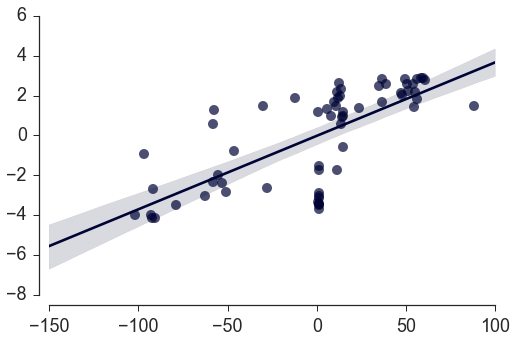

In [26]:
sns.set_context('notebook', font_scale=1.8)
sns.set_style('ticks')
fig=plt.figure(figsize=(8,5))
sns.regplot(cheb_avg_embed[0][:,1], corr_avg_embed[0][:,1], scatter_kws={"s": 100, "marker":"o", "alpha":0.7}, 
            color=sns.xkcd_palette(['dark navy'])[0])
#plt.yticks([-4, -2, 0, 2, 4, 6])
#plt.xticks([-80, -40, 0, 40, 80, 120])
sns.despine(trim=True, offset=10)
plt.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/figs_longpath3_rad4/scatter_connectivity_negprofiles_comp2.png')

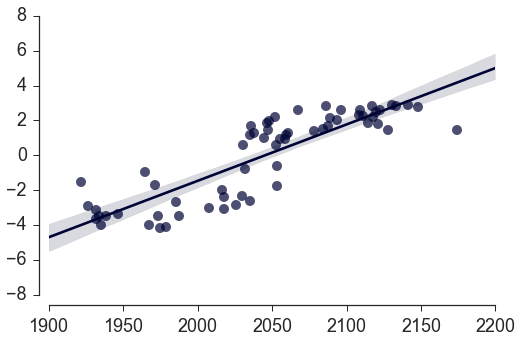

In [28]:
sns.set_context('notebook', font_scale=1.8)
sns.set_style('ticks')
fig=plt.figure(figsize=(8,5))
sns.regplot(t1_windows_avg, corr_avg_embed[0][:,1], scatter_kws={"s": 100, "marker":"o", "alpha":0.7}, 
            color=sns.xkcd_palette(['dark navy'])[0])
#plt.yticks([-4, -2, 0, 2, 4, 6])
#plt.xticks([-80, -40, 0, 40, 80, 120])
sns.despine(trim=True, offset=10)
plt.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/figs_longpath3_rad4/scatter_connectivity_comp2_t1avg.png')

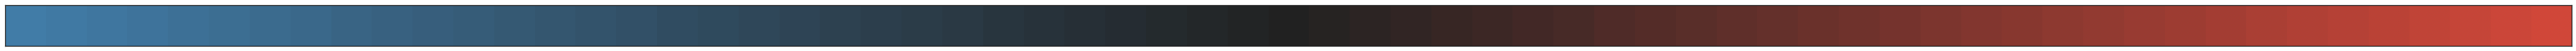

In [31]:
div_cmap, div_cmap_255 = make_div_cmap(len(combined_windows))
sns.palplot(div_cmap)

In [32]:
mid = int(len(div_cmap)/2)
cdict = {'red':   ((0.0,  div_cmap[0][0], div_cmap[0][0]),
                   (0.5,  div_cmap[mid][0], div_cmap[mid][0]),
                   (1.0,  div_cmap[-1][0], div_cmap[-1][0])),

         'green': ((0.0,  div_cmap[0][1], div_cmap[0][1]),
                   (0.5,  div_cmap[mid][1], div_cmap[mid][1]),
                   (1.0,  div_cmap[-1][1], div_cmap[-1][1])),

         'blue':  ((0.0,  div_cmap[0][2], div_cmap[0][2]),
                   (0.5,  div_cmap[mid][2], div_cmap[mid][2]),
                   (1.0,  div_cmap[-1][2], div_cmap[-1][2]))}

julia = matplotlib.colors.LinearSegmentedColormap('julia', cdict)
plt.register_cmap(name='julia', data=cdict)

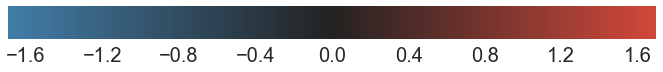

In [33]:
cont_div_cmap = plt.get_cmap('julia')
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=2)
norm = matplotlib.colors.Normalize(vmin=np.min(corr_avg_embed[0][1]), vmax=-np.min(corr_avg_embed[0][1]))
#norm = matplotlib.colors.Normalize(vmin=3, vmax=-3)

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cont_div_cmap,
                                norm=norm,
                                orientation='horizontal')

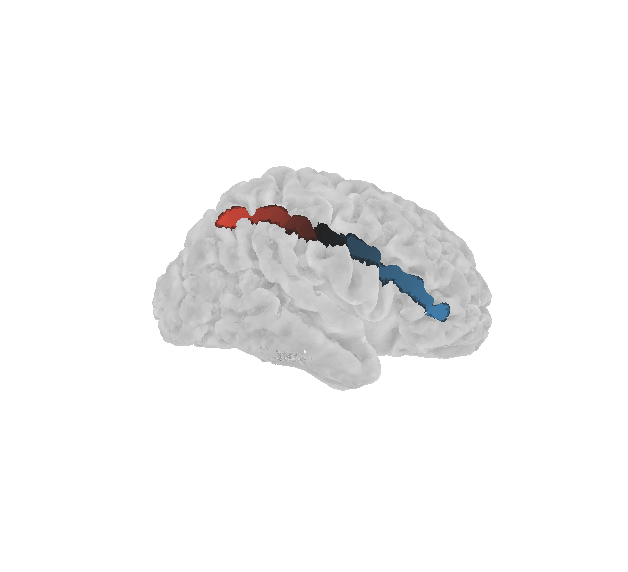

In [41]:
dist_surf=np.zeros_like(v[:,1])
for window in range(len(combined_windows)):
    dist_surf[combined_windows[window]]=window-31.1

sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=dist_surf, bg_map=sulc, threshold=1e-50,
                        elev=180,azim=0, figsize=(11,10), darkness=0.6, cmap=plt.get_cmap('julia'))

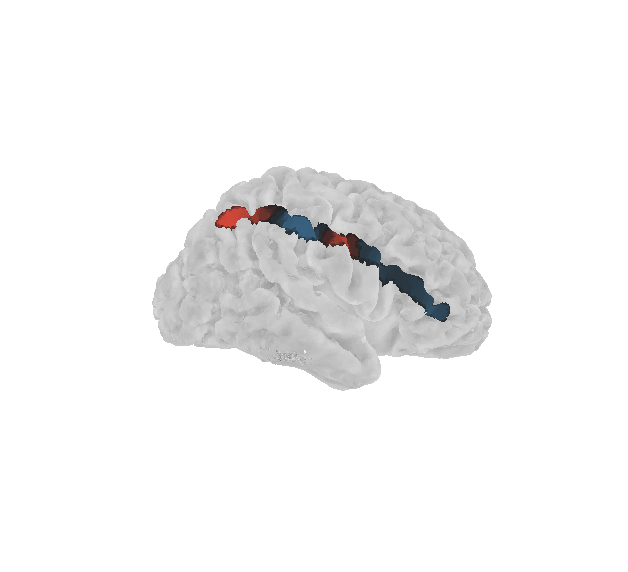

In [58]:
fc_surf=np.zeros_like(v[:,1])
for window in range(len(combined_windows)):
    fc_surf[combined_windows[window]]=corr_avg_embed[0][window][1]

sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=-fc_surf, bg_map=sulc, threshold=1e-50,
                        elev=180,azim=0, figsize=(11,10), darkness=0.6, cmap=plt.get_cmap('julia'))

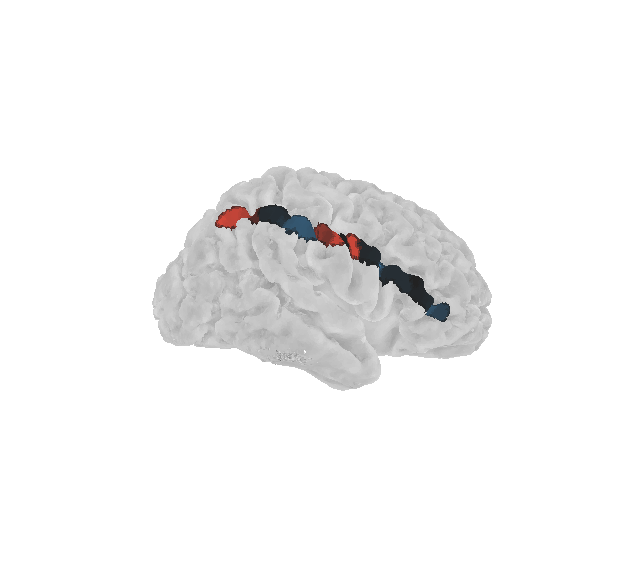

In [59]:
t1_surf=np.zeros_like(v[:,0])
for window in range(len(combined_windows)):
    t1_surf[combined_windows[window]]=cheb_avg_embed[0][window][1]

sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=t1_surf, bg_map=sulc, threshold=1e-50,
                        elev=180,azim=0, figsize=(11,10), darkness=0.6, cmap=plt.get_cmap('julia'))

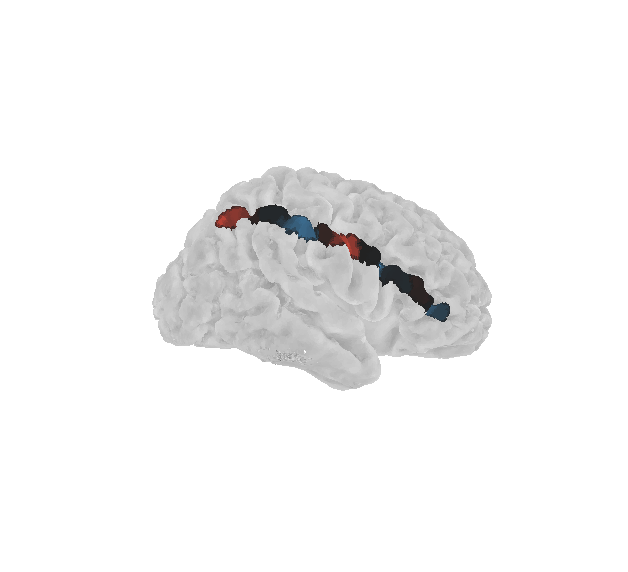

In [68]:
t1avg_surf=np.zeros_like(v[:,0])
for window in range(len(combined_windows)):
    t1avg_surf[combined_windows[window]]=t1_windows_avg_mean_centered[window]

sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=-t1avg_surf, bg_map=sulc, threshold=1e-50,
                        elev=180,azim=0, figsize=(11,10), darkness=0.6, cmap=plt.get_cmap('julia'))

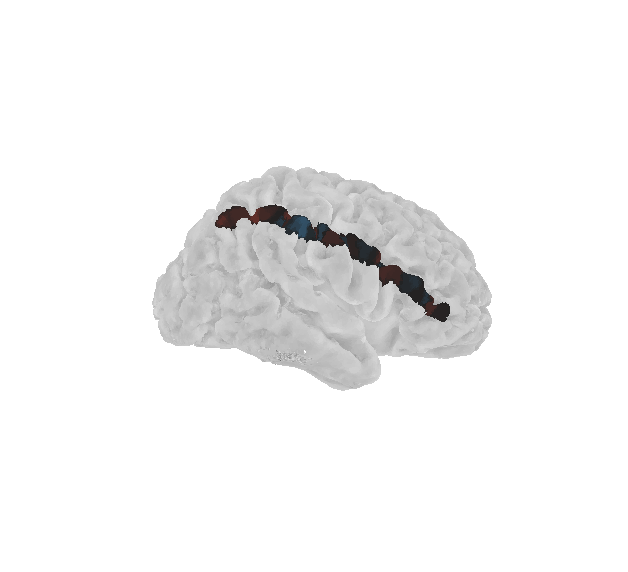

In [111]:
t1_surf_norm=np.zeros_like(v[:,0])
for window in range(len(combined_windows)):
    t1_surf_norm[combined_windows[window]]=cheb_avg_norm_embed[0][window][3]

sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=t1_surf_norm, bg_map=sulc, threshold=1e-50,
                        elev=180,azim=0, figsize=(11,10), darkness=0.6, cmap=plt.get_cmap('julia'))

In [27]:
fc_cluster = [] 
cluster_labels = []
for k in [2,3,4,5,6,7,8,9,10]:
    fc_cluster.append(kmeans(corr_avg_embed[0], k))
    cluster_labels_k = []
    for l in np.unique(fc_cluster[k-2]):
        cluster = []
        for w in np.where(fc_cluster[k-2]==l)[0]:
            cluster += combined_windows[w]
        cluster_labels_k.append(cluster)
    cluster_labels.append(cluster_labels_k)

In [28]:
cluster_profiles = []
for k in [2,3,4,5,6,7,8,9,10]:
    cluster_k_profiles = []
    for cluster in cluster_labels[k-2]:
        coeff, poly = chebapprox(profiles[cluster], degree=4)
        cluster_k_profiles.append(coeff)
    cluster_profiles.append(cluster_k_profiles)

In [29]:
nk=7

In [30]:
subcluster_labels =[]
subcluster_colors = []

count=0
current_k = fc_cluster[nk-2][0]
subcluster_labels.append(combined_windows[0])
subcluster_colors.append(current_k)

for window in range(len(combined_windows)):
    if fc_cluster[nk-2][window] == current_k:
        subcluster_labels[count] += combined_windows[window]
    else:
        count += 1
        current_k = fc_cluster[nk-2][window]
        subcluster_colors.append(current_k)
        subcluster_labels.append(combined_windows[window])

In [31]:
subcluster_profiles = []
for cluster in subcluster_labels:
    coeff, poly = chebapprox(profiles[cluster], degree=4)
    subcluster_profiles.append(coeff)

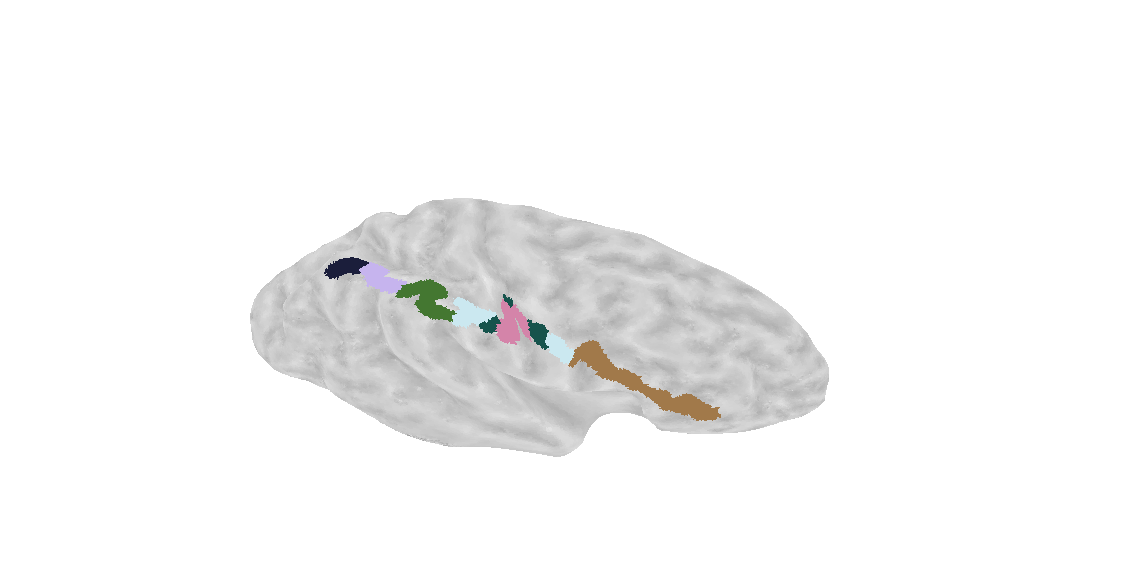

In [101]:
sns.set_style('white')
plot=plot_surf_label(v_inf, f_inf, labels=tuple(cluster_labels[nk-2]), 
                     cpal=sns.color_palette('cubehelix', nk), bg_map=sulc,
                     elev=220,azim=-20, figsize=(20,10), darkness=0.5)

In [1]:
sns.set_style('white')
plot=plot_surf_label(v, f, labels=tuple(cluster_labels[nk-2]), 
                     cpal=sns.color_palette('cubehelix', nk), bg_map=sulc,
                     elev=180,azim=0, figsize=(20,10), darkness=0.5)

NameError: name 'sns' is not defined

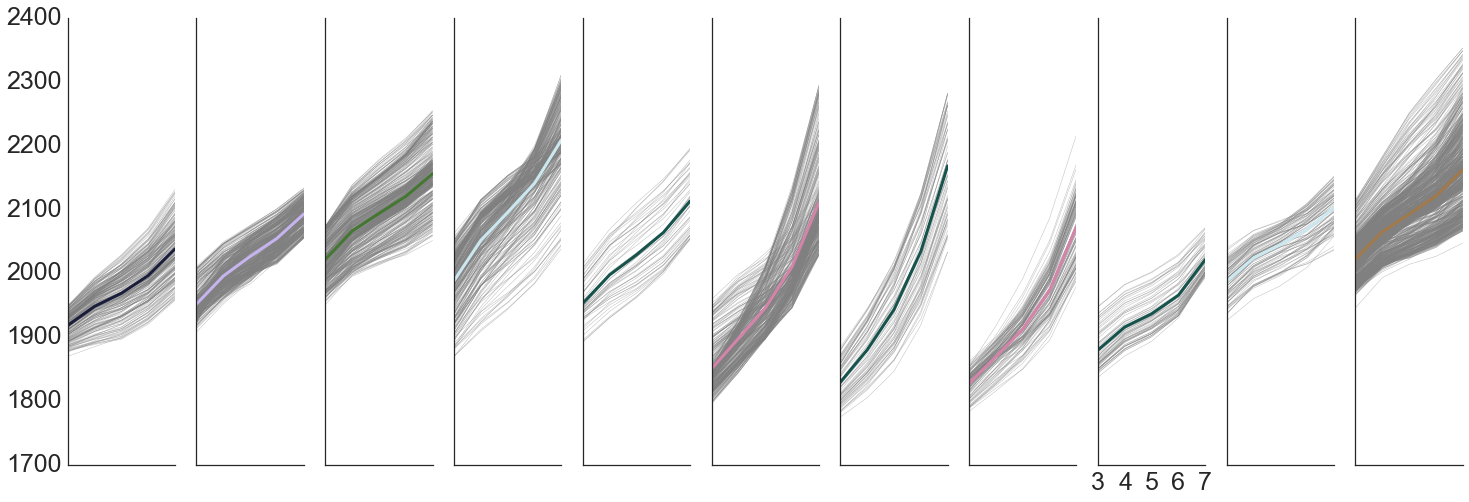

In [106]:
sns.set_context('notebook', font_scale=2.5)
sns.set_style('white')
x=[3,4,5,6,7]
fig = plt.figure(figsize=(25,8))
for i in range(len(subcluster_labels)):
    ax = fig.add_subplot(1,len(subcluster_labels),i+1)
    ax.set_ylim([1700, 2400])
    for pro in subcluster_profiles[-(i+1)]:
        plt.plot(x,np.polynomial.chebyshev.chebval(np.arange(pro.shape[0]), pro),color='gray', alpha=0.5, linewidth=0.5)
    plt.plot(x,np.polynomial.chebyshev.chebval(np.arange(pro.shape[0]), np.mean(subcluster_profiles[-(i+1)], axis=0)), 
                                                       color=sns.color_palette('cubehelix', nk)[int(subcluster_colors[-(i+1)])-1], linewidth=3)
    plt.xticks([])
    if i>0:
        plt.yticks([])
    if i==8:
        plt.xticks([3,4,5,6,7])
    #plt.title(str(i+1))
sns.despine()

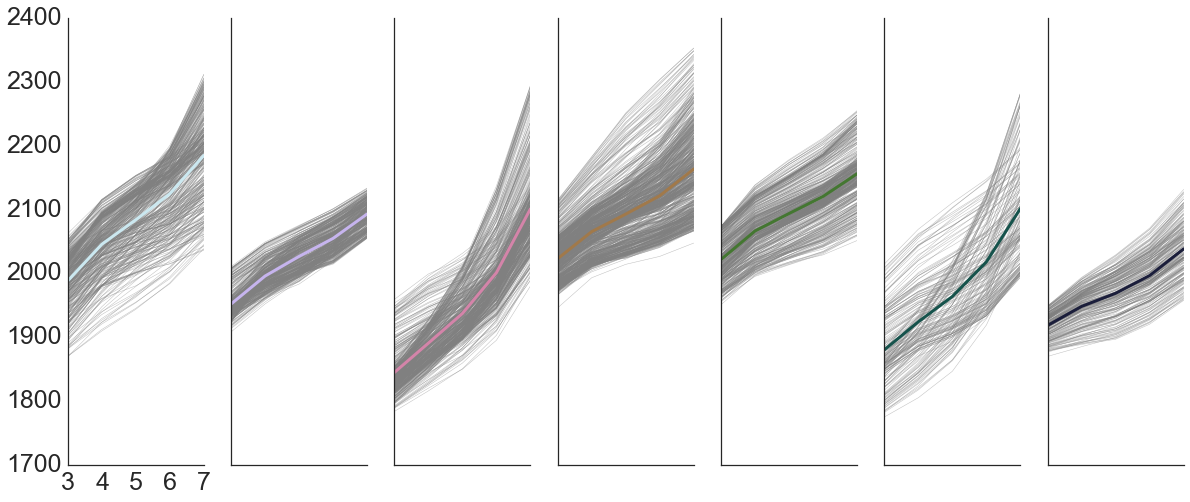

In [103]:
sns.set_context('notebook', font_scale=2.5)
sns.set_style('white')
x=[3,4,5,6,7]
fig = plt.figure(figsize=(20,8))
for i in range(len(cluster_labels[nk-2])):
    ax = fig.add_subplot(1,len(cluster_labels[nk-2]),i+1)
    ax.set_ylim([1700, 2400])
    for pro in cluster_profiles[nk-2][-(i+1)]:
        plt.plot(x,np.polynomial.chebyshev.chebval(np.arange(pro.shape[0]), pro),color='gray', alpha=0.5, linewidth=0.5)
    plt.plot(x,np.polynomial.chebyshev.chebval(np.arange(pro.shape[0]), np.mean(cluster_profiles[nk-2][-(i+1)], axis=0)), 
                                                       color=sns.color_palette('cubehelix', nk)[-(i+1)], linewidth=3)
    plt.xticks([])
    if i>0:
        plt.yticks([])
    if i==0:
        plt.xticks([3,4,5,6,7])
    #plt.title(str(i+1))
sns.despine()

In [35]:
means = {}

for c in range(len(cluster_profiles[nk-2])):
    means[c] = np.mean(cluster_profiles[nk-2][c][:,0])
sorted_means = sorted(means.items(), key=operator.itemgetter(1))

sorted_plot_list=[]
sorted_cluster_list=[]
sorted_pal=[]
for m in range(len(sorted_means)):
    sorted_plot_list+=list(cluster_profiles[nk-2][sorted_means[m][0]][:,0])
    sorted_cluster_list+=len(list(cluster_profiles[nk-2][sorted_means[m][0]][:,0]))*[('k%s'%str(sorted_means[m][0]+1))]
    sorted_pal.append(sns.color_palette('cubehelix', nk)[sorted_means[m][0]])
    
sorted_plot_df=pd.DataFrame(columns=['coeff 0', 'cluster'])
sorted_plot_df['coeff 0']=sorted_plot_list
sorted_plot_df['cluster']=sorted_cluster_list

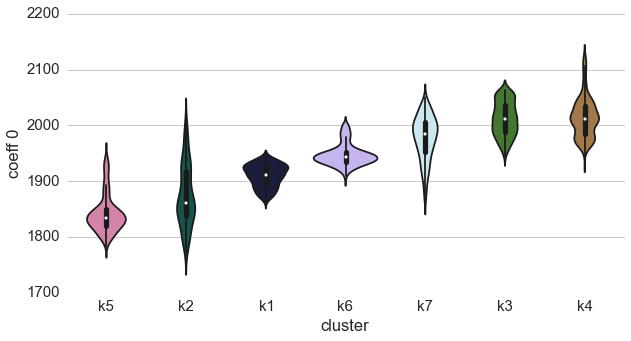

In [36]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.5)
fig = plt.figure(figsize=(nk+3,5))
sns.violinplot(x='cluster', y='coeff 0',data=sorted_plot_df, palette=sorted_pal, inner='box', saturation=1)
sns.despine(left=True, bottom=True)

# Do this based on all coefficients

In [37]:
jsd_mat = np.zeros((nk, nk))
for i in range(nk):
    for j in range(nk):
        jsd_total = 0
        for c in range(5):
            _, jsd=jensenshannon([np.asarray(cluster_profiles[nk-2][i][:,c]), np.asarray(cluster_profiles[nk-2][j][:,c])])
            jsd_total += jsd
        jsd_mat[i][j] = jsd_total/5

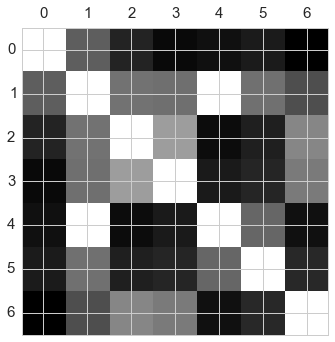

In [38]:
plt.matshow(jsd_mat)

## coefficients and profiles

In [39]:
corr_embed_dict={}
cheb_embed_dict={}
for cw in range(len(combined_windows)):
    corr_embed_dict[cw]=corr_avg_embed[0][:,1][cw]
    cheb_embed_dict[cw]=cheb_avg_embed[0][:,1][cw]
    
sorted_corr_embed = sorted(corr_embed_dict.items(), key=operator.itemgetter(1))
sorted_cheb_embed = sorted(cheb_embed_dict.items(), key=operator.itemgetter(1))

sorted_corr_embed_vals=[y for (x,y) in sorted_corr_embed]
sorted_cheb_embed_vals=[y for (x,y) in sorted_cheb_embed]
sorted_corr_embed_keys=[x for (x,y) in sorted_corr_embed]
sorted_cheb_embed_keys=[x for (x,y) in sorted_cheb_embed]

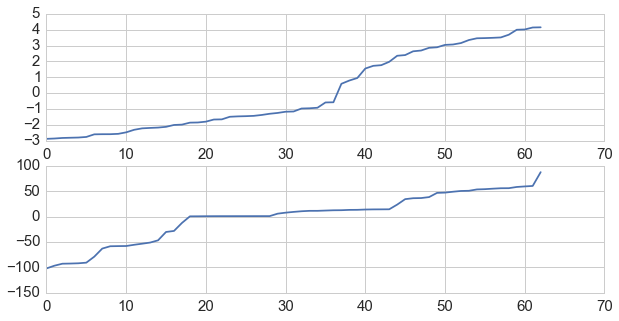

In [40]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
plt.plot(sorted_corr_embed_vals)
fig.add_subplot(212)
plt.plot(sorted_cheb_embed_vals)

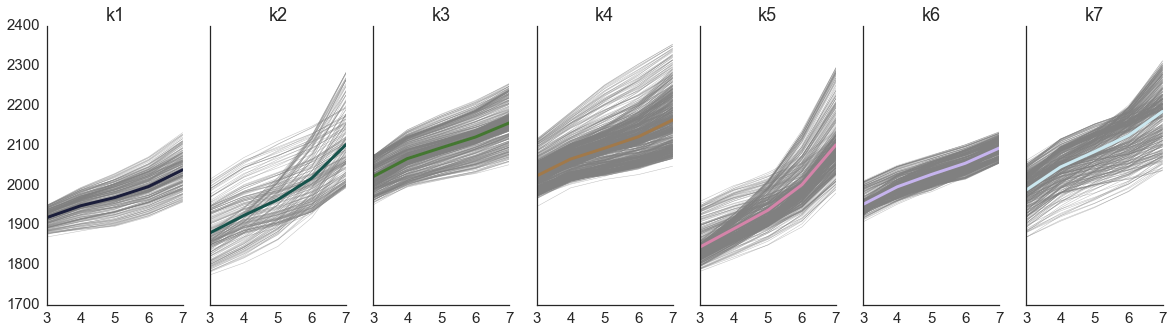

In [41]:
sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')
sol=7
x=[3,4,5,6,7]
fig = plt.figure(figsize=(20,5))
for i in range(sol):
    ax = fig.add_subplot(1,sol,i+1)
    ax.set_ylim([1700, 2400])
    for pro in cluster_profiles[sol-2][i]:
        plt.plot(x,np.polynomial.chebyshev.chebval(np.arange(pro.shape[0]), pro),color='gray', alpha=0.5, linewidth=0.5)
    plt.plot(x,np.polynomial.chebyshev.chebval(np.arange(pro.shape[0]), np.mean(cluster_profiles[sol-2][i], axis=0)), 
                                                       color=sns.color_palette('cubehelix',sol)[i], linewidth=3)
    plt.xticks([3,4,5,6,7])
    if i>0:
        plt.yticks([])
    plt.title('k'+str(i+1))
sns.despine()

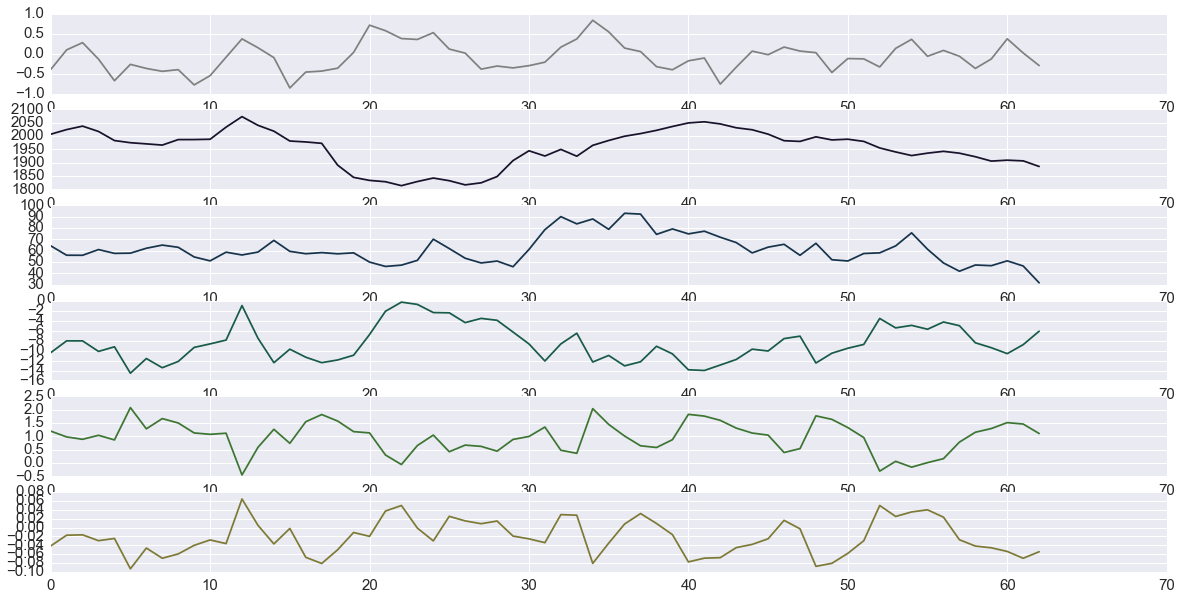

In [42]:
sns.set_style('darkgrid')
no_plots=6

fig = plt.figure(figsize=(20,10))
fig.add_subplot(no_plots,1,1)
plt.plot(sulc_avg, color='gray')

for i in range(5):
    fig.add_subplot(no_plots,1,i+2)
    plt.plot(cheb_avg[:,i], color=sns.color_palette('cubehelix', 10)[i])

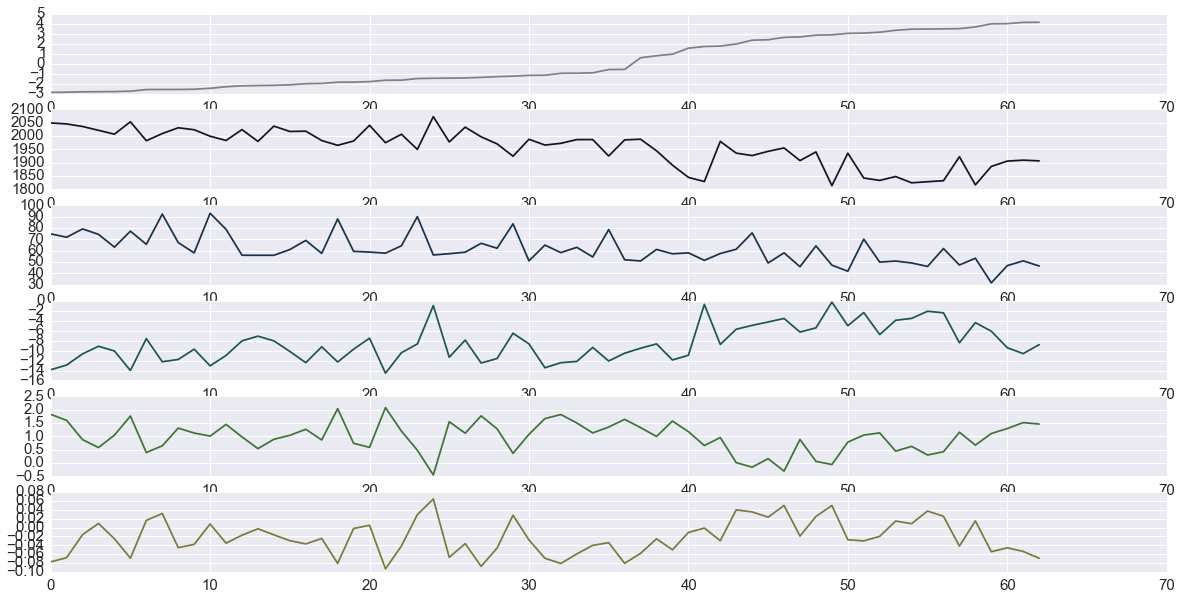

In [43]:
sorted_cheb_avg=np.asarray([cheb_avg[m] for (m,y) in sorted_corr_embed])
sns.set_style('darkgrid')
no_plots=6

fig = plt.figure(figsize=(20,10))
fig.add_subplot(no_plots,1,1)
plt.plot(sorted_corr_embed_vals, color='gray')

for i in range(5):
    fig.add_subplot(no_plots,1,i+2)
    plt.plot(sorted_cheb_avg[:,i], color=sns.color_palette('cubehelix', 10)[i])

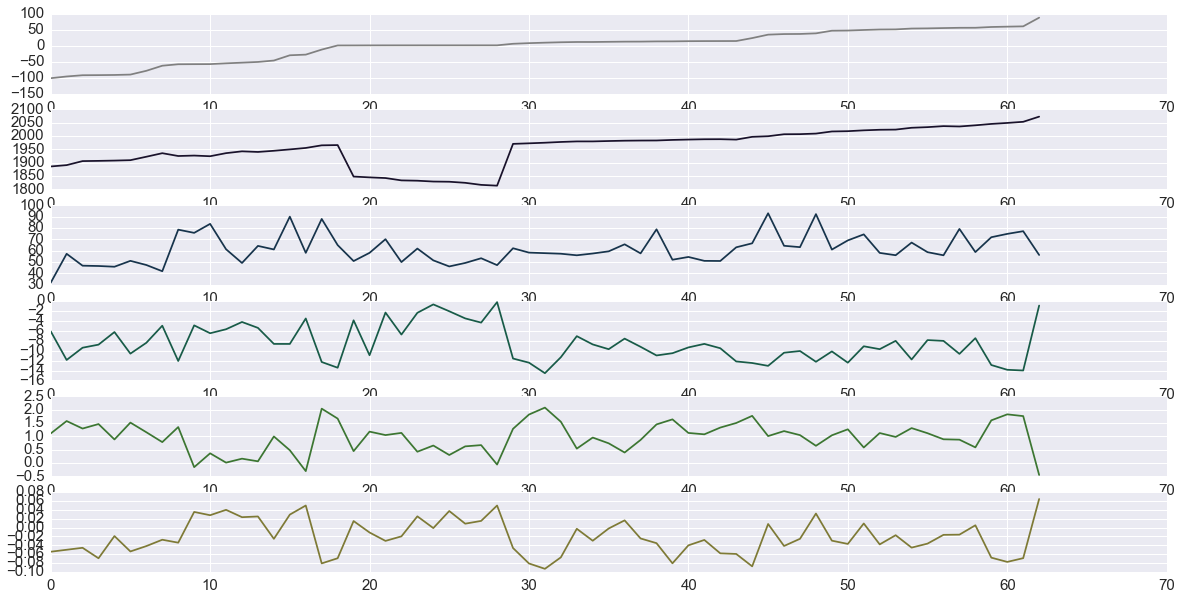

In [44]:
sorted_cheb_avg=np.asarray([cheb_avg[m] for (m,y) in sorted_cheb_embed])
sns.set_style('darkgrid')
no_plots=6

fig = plt.figure(figsize=(20,10))
fig.add_subplot(no_plots,1,1)
plt.plot(sorted_cheb_embed_vals, color='gray')

for i in range(5):
    fig.add_subplot(no_plots,1,i+2)
    plt.plot(sorted_cheb_avg[:,i], color=sns.color_palette('cubehelix', 10)[i])

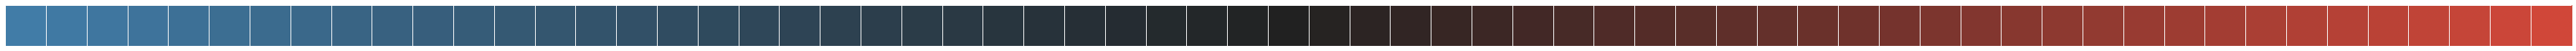

In [45]:
div_cmap, _ = make_div_cmap(len(combined_windows))
sns.palplot(div_cmap)

In [46]:
sorted_combined_windows=[]
for key in sorted_corr_embed_keys:
    sorted_combined_windows.append(combined_windows[key])

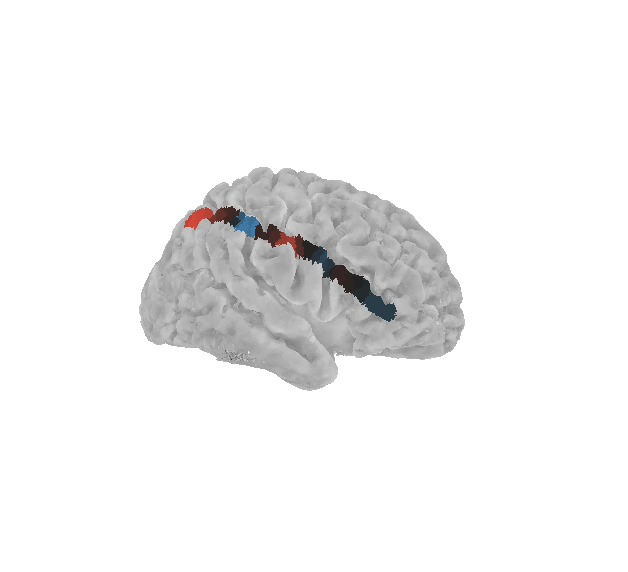

In [47]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(sorted_combined_windows), cpal=div_cmap, bg_map=sulc, 
                        elev=180,azim=-20, figsize=(11,10), darkness=0.8)

In [48]:
sorted_cheb_avg=np.asarray([cheb_avg[m] for (m,y) in sorted_corr_embed])

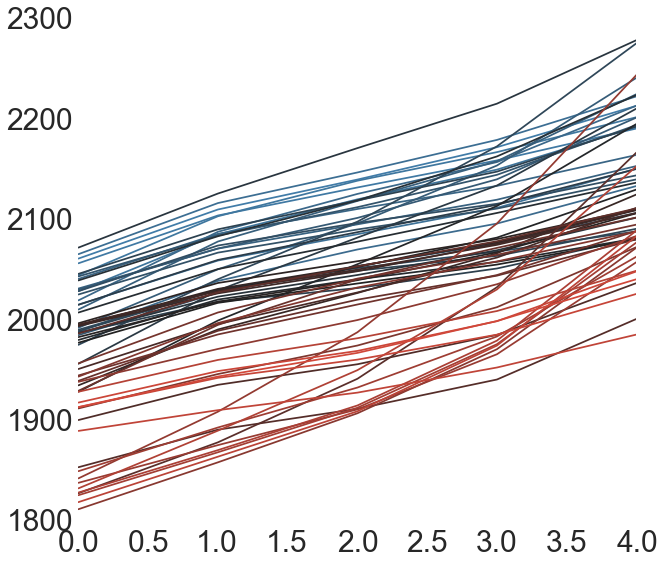

In [81]:
sns.set_style('white')
sns.set_context('notebook', font_scale=3)
alpha=1
x = np.arange(cheb_avg.shape[1])
fig = plt.figure(figsize=(10,9))

###################################################################################
fig.add_subplot(111)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0], 
                                                           sorted_cheb_avg[w][1], 
                                                           sorted_cheb_avg[w][2],
                                                           sorted_cheb_avg[w][3], 
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
#plt.ylabel('Coefficient 0-4')
sns.despine(left=True, bottom=True)
#fig.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/sorted_profiles_coeff04.svg')

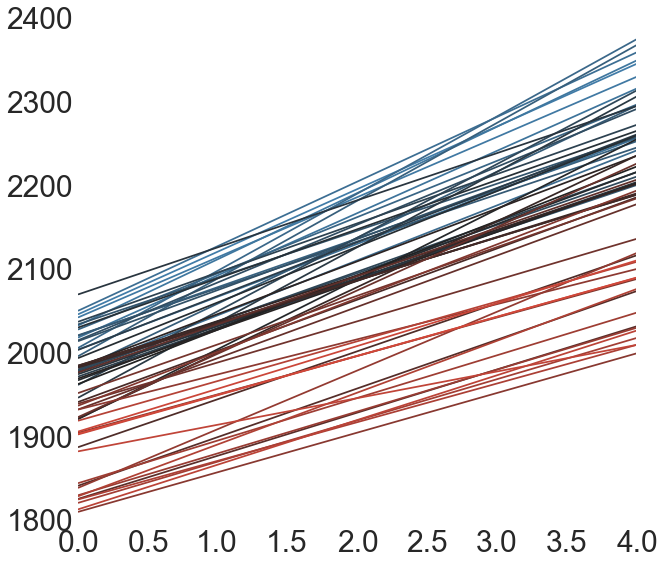

In [84]:
sns.set_style('white')
sns.set_context('notebook', font_scale=3)
alpha=1
x = np.arange(cheb_avg.shape[1])
fig = plt.figure(figsize=(10,9))

###################################################################################
fig.add_subplot(111)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0], 
                                                           sorted_cheb_avg[w][1], 
                                                           #sorted_cheb_avg[w][2],
                                                           #sorted_cheb_avg[w][3], 
                                                           #sorted_cheb_avg[w][4]
                                                          ])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
#plt.ylabel('Coefficient 0-4')
sns.despine(left=True, bottom=True)
#fig.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/sorted_profiles_coeff01.svg')

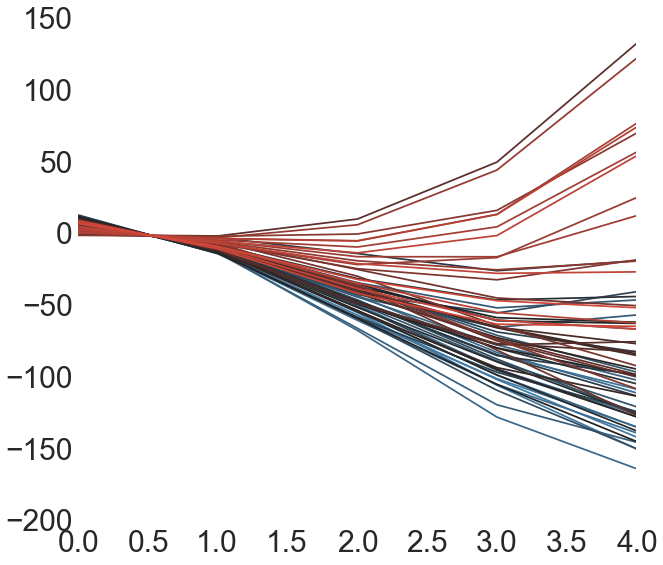

In [80]:
sns.set_style('white')
sns.set_context('notebook', font_scale=3)
alpha=1
x = np.arange(cheb_avg.shape[1])
fig = plt.figure(figsize=(10,9))

###################################################################################
fig.add_subplot(111)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           sorted_cheb_avg[w][2], 
                                                           sorted_cheb_avg[w][3],
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
#plt.ylabel('Coefficient 0-4')
sns.despine(left=True, bottom=True)
#fig.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/sorted_profiles_coeff24.svg')

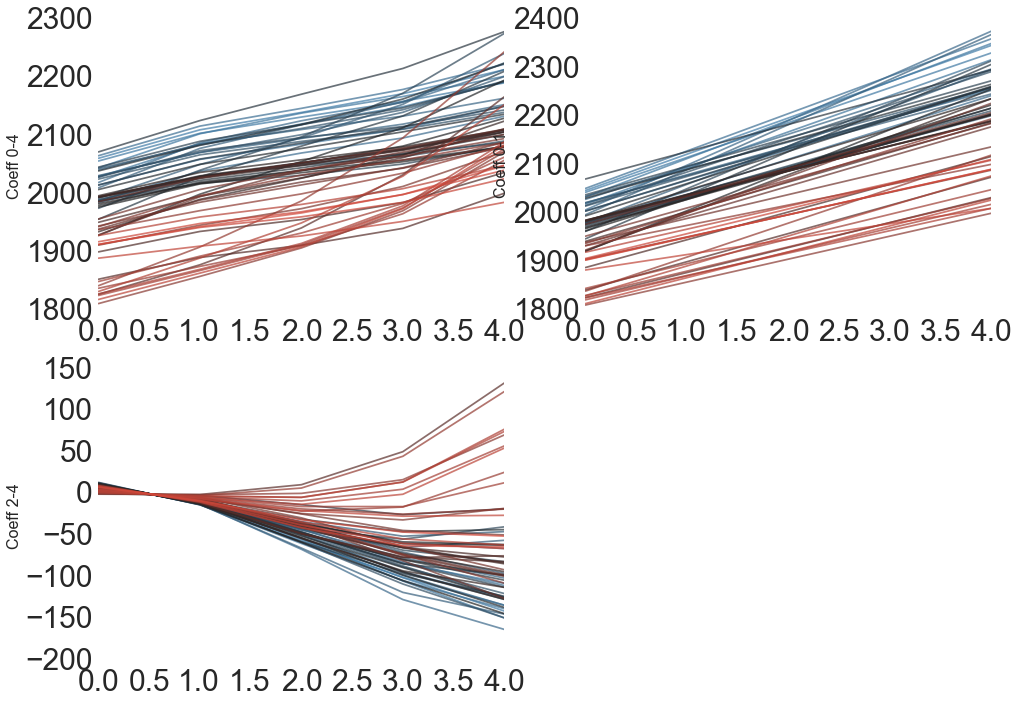

In [51]:
sns.set_style('white')
alpha=0.7
x = np.arange(cheb_avg.shape[1])
fig = plt.figure(figsize=(16,24))

###################################################################################
fig.add_subplot(421)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0], 
                                                           sorted_cheb_avg[w][1], 
                                                           sorted_cheb_avg[w][2],
                                                           sorted_cheb_avg[w][3], 
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-4', fontsize=16)

###################################################################################
fig.add_subplot(422)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0],
                                                           sorted_cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-1', fontsize=16)


###################################################################################
fig.add_subplot(423)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           sorted_cheb_avg[w][2],
                                                           sorted_cheb_avg[w][3], 
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2-4', fontsize=16)


sns.despine(left=True, bottom=True)

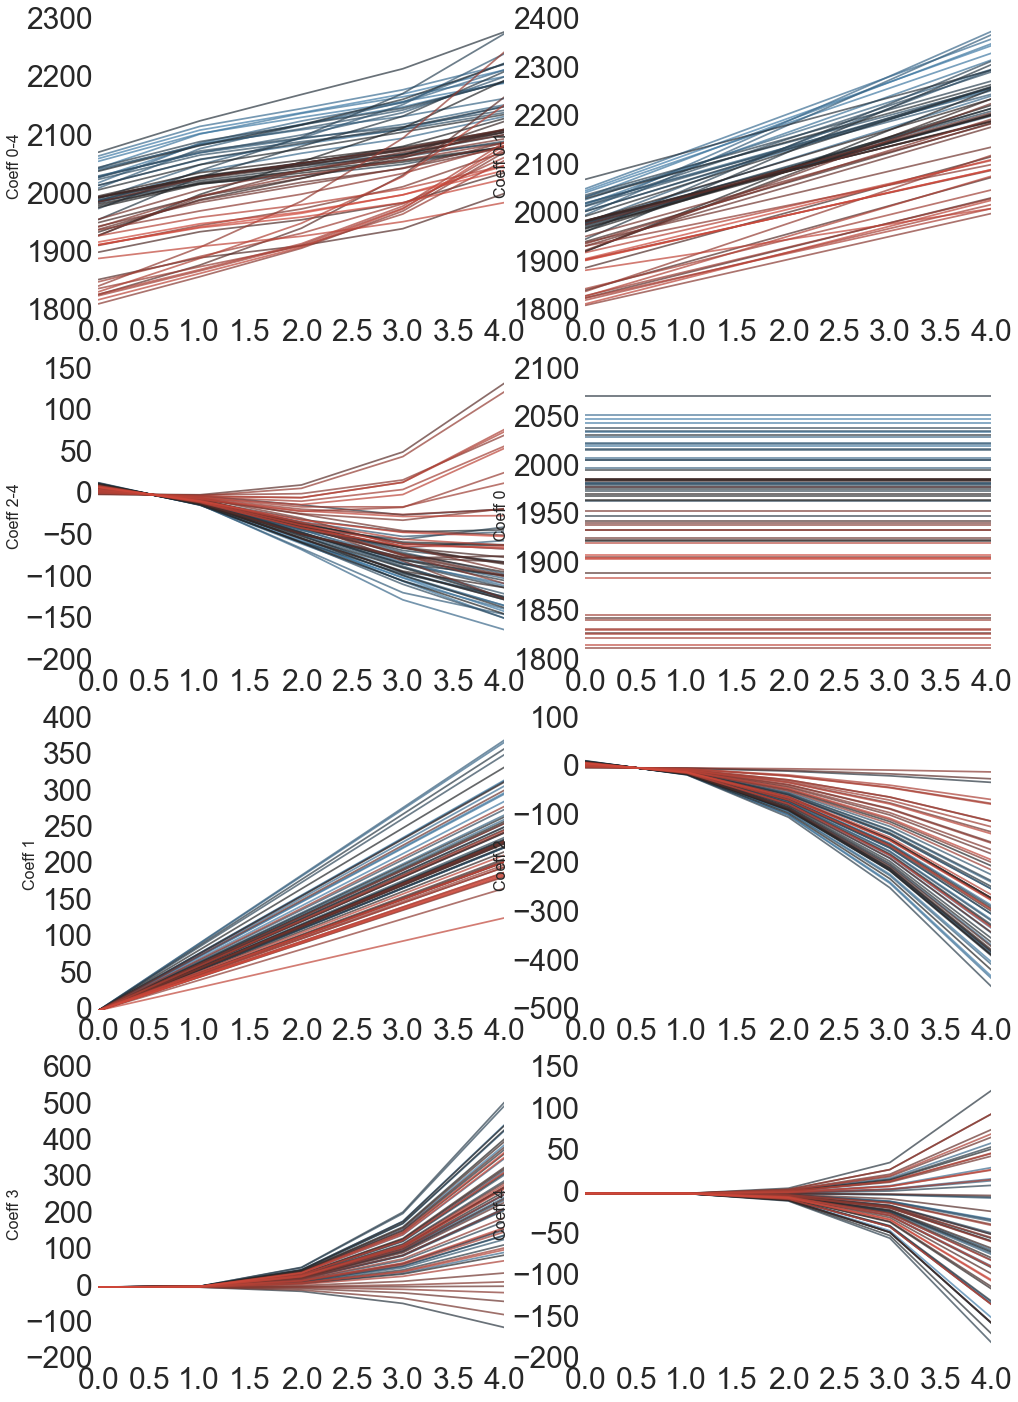

In [52]:
sns.set_style('white')
alpha=0.7
x = np.arange(cheb_avg.shape[1])
fig = plt.figure(figsize=(16,24))

###################################################################################
fig.add_subplot(421)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0], 
                                                           sorted_cheb_avg[w][1], 
                                                           sorted_cheb_avg[w][2],
                                                           sorted_cheb_avg[w][3], 
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-4', fontsize=16)

###################################################################################
fig.add_subplot(422)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0],
                                                           sorted_cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-1', fontsize=16)


###################################################################################
fig.add_subplot(423)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           sorted_cheb_avg[w][2],
                                                           sorted_cheb_avg[w][3], 
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2-4', fontsize=16)


###################################################################################
fig.add_subplot(424)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [sorted_cheb_avg[w][0],
                                                          0,0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0', fontsize=16)

###################################################################################
fig.add_subplot(425)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0, 
                                                           sorted_cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 1', fontsize=16)

###################################################################################
fig.add_subplot(426)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           sorted_cheb_avg[w][2],
                                                          0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2', fontsize=16)

###################################################################################
fig.add_subplot(427)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,
                                                           sorted_cheb_avg[w][3],
                                                          0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 3', fontsize=16)

###################################################################################
fig.add_subplot(428)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,0,
                                                           sorted_cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 4', fontsize=16)

###################################################################################
sns.despine(left=True, bottom=True)

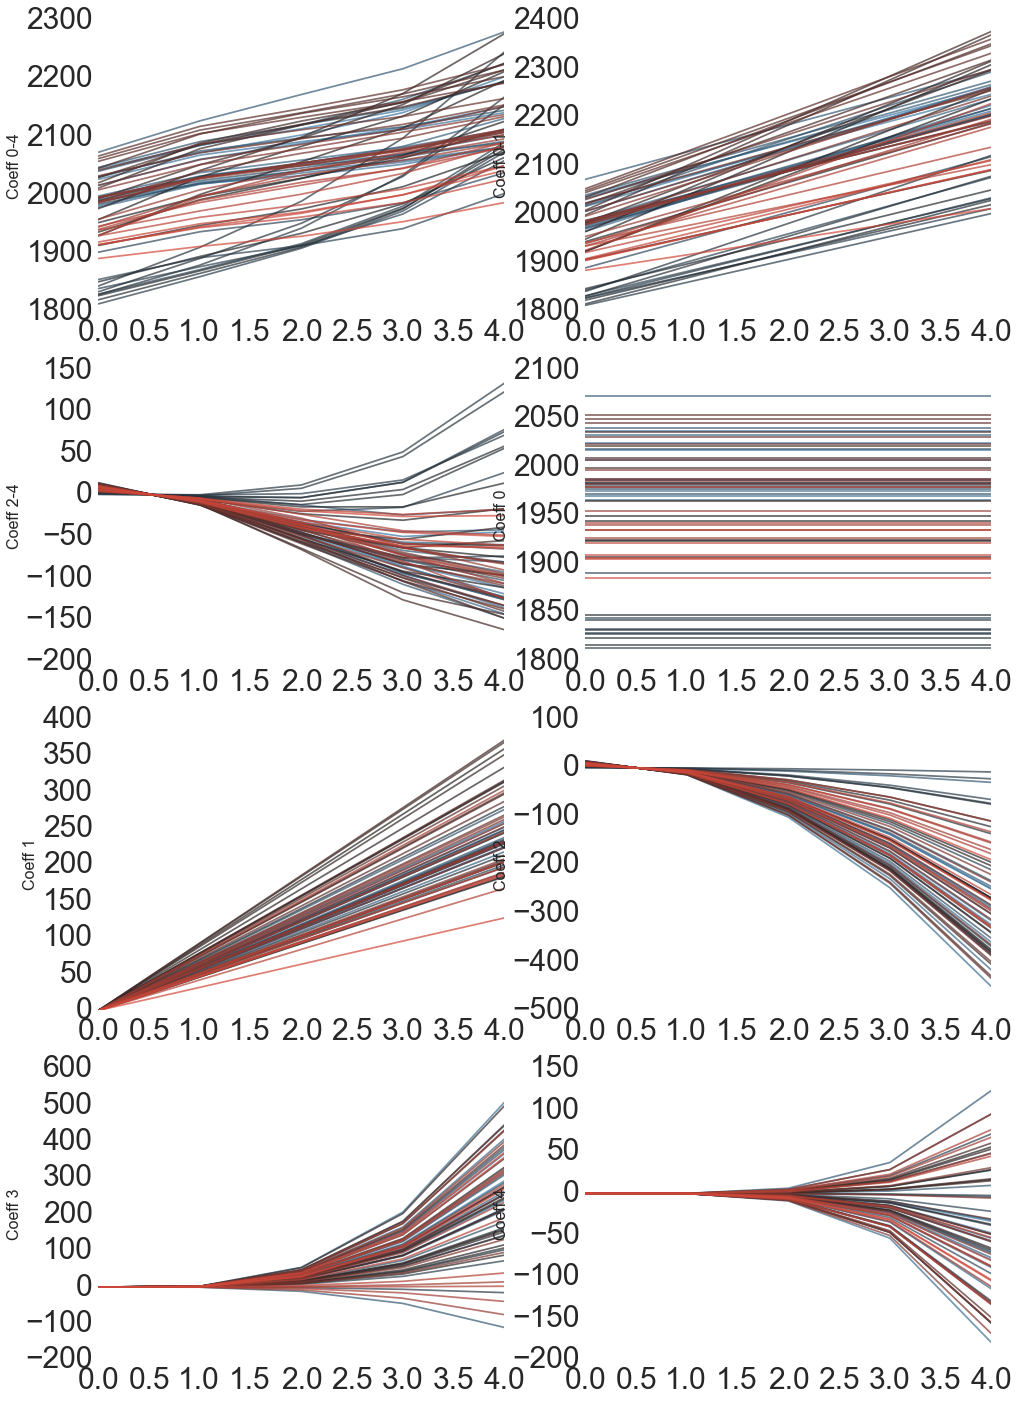

In [53]:
sns.set_style('white')
alpha=0.7
x = np.arange(cheb_avg.shape[1])
fig = plt.figure(figsize=(16,24))

###################################################################################
fig.add_subplot(421)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0], 
                                                           cheb_avg[w][1], 
                                                           cheb_avg[w][2],
                                                           cheb_avg[w][3], 
                                                           cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-4', fontsize=16)

###################################################################################
fig.add_subplot(422)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0],
                                                           cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0-1', fontsize=16)


###################################################################################
fig.add_subplot(423)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           cheb_avg[w][2],
                                                           cheb_avg[w][3], 
                                                           cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2-4', fontsize=16)


###################################################################################
fig.add_subplot(424)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0],
                                                          0,0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 0', fontsize=16)

###################################################################################
fig.add_subplot(425)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0, 
                                                           cheb_avg[w][1],
                                                          0,0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 1', fontsize=16)

###################################################################################
fig.add_subplot(426)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,
                                                           cheb_avg[w][2],
                                                          0,0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 2', fontsize=16)

###################################################################################
fig.add_subplot(427)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,
                                                           cheb_avg[w][3],
                                                          0])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 3', fontsize=16)

###################################################################################
fig.add_subplot(428)
cheb_avg_plot = np.zeros((cheb_avg.shape[0],cheb_avg.shape[1]))
for w in range(cheb_avg.shape[0]):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,0,
                                                           cheb_avg[w][4]])
for i in range(cheb_avg_plot.shape[0]):
    r,g,b=div_cmap[i][0], div_cmap[i][1], div_cmap[i][2]
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.ylabel('Coeff 4', fontsize=16)

###################################################################################
sns.despine(left=True, bottom=True)

## modularity

In [54]:
import networkx as nx
import community as com

ImportError: No module named community

In [ ]:
fc_graph = nx.from_numpy_matrix(corr_avg_affinity)
fc_part = com.best_partition(fc_graph)
fc_mod = com.modularity(fc_part, fc_graph)
fc_dendr = com.generate_dendogram(fc_graph)

print 'modularity', fc_mod
print 'modules', len(np.unique(fc_part.values()))

In [ ]:
fc_mod_surf = np.zeros_like(v[:,0])
for w in fc_part.keys():
    fc_mod_surf[combined_windows[w]] = fc_part[w]+1
    
fc_mod_labels = []
for l in np.unique(fc_mod_surf):
    if l > 0:
        fc_mod_labels.append(list(np.where(fc_mod_surf==l)[0]))

In [ ]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(fc_mod_labels), cpal=sns.color_palette('cubehelix', 4), bg_map=sulc, 
                        elev=180,azim=-20, figsize=(11,10), darkness=0.8)

In [ ]:
t1_graph = nx.from_numpy_matrix(cheb_avg_affinity)
t1_part = com.best_partition(t1_graph)
t1_mod = com.modularity(t1_part, t1_graph)
t1_dendr = com.generate_dendogram(t1_graph)

print 'modularity', t1_mod
print 'modules', len(np.unique(t1_part.values()))

In [ ]:
np.unique(com.partition_at_level(t1_dendr,len(t1_dendr)-1).values())

In [ ]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(t1_mod_labels), cpal=sns.color_palette('cubehelix', 7), bg_map=sulc, 
                        elev=180,azim=-20, figsize=(11,10), darkness=0.8)